In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.inspection import permutation_importance

# Gradient boosting libraries
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb

# NLP libraries
import nltk

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sarthak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Improving data by extracting powerful parameters

In [3]:
# Feature extraction functions
def extract_years_experience(text):
    """Extract years of experience requirement from job description"""
    if not isinstance(text, str):
        return 0
        
    # Common patterns for years of experience
    patterns = [
        r'(\d+)\+?\s*years?(?:\s*of)?\s*experience',
        r'(\d+)-(\d+)\s*years?(?:\s*of)?\s*experience',
        r'experience:\s*(\d+)\+?\s*years?',
        r'experience(?:\s*of)?\s*(\d+)\+?\s*years?',
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text.lower())
        if match:
            # If range like "3-5 years", take the average
            if len(match.groups()) > 1 and match.group(2):
                return (int(match.group(1)) + int(match.group(2))) / 2
            return int(match.group(1))
    
    return 0  # Default to 0 if no match found

In [4]:
def extract_education_level(text):
    """Extract education level requirement from job description"""
    if not isinstance(text, str):
        return 0
        
    text = text.lower()
    
    # Education level scoring (higher number = higher education)
    if re.search(r'phd|doctorate|doctoral', text):
        return 4
    elif re.search(r'master\'?s|ms degree|m.s.|mba|m.b.a', text):
        return 3
    elif re.search(r'bachelor\'?s|bachelors|bs degree|b.s.|ba degree|b.a.', text):
        return 2
    elif re.search(r'associate\'?s|associates|community college', text):
        return 1
    else:
        return 0

In [5]:
def extract_seniority(title):
    """Extract seniority level from job title"""
    if not isinstance(title, str):
        return 0
        
    title = title.lower()
    
    # Seniority scoring (higher = more senior)
    if re.search(r'chief|ceo|cto|cfo|coo|president|vp|vice president', title):
        return 5
    elif re.search(r'director|head', title):
        return 4
    elif re.search(r'senior|sr|lead', title):
        return 3
    elif re.search(r'manager|supervisor', title):
        return 2
    elif re.search(r'junior|jr|associate|intern|assistant', title):
        return 1
    else:
        return 2  # Default to mid-level if no indicator


### Load the dataset

In [6]:
# Load the enriched job postings data
data = pd.read_csv('processed_data/processed_linkedin_postings_salary.csv')

In [7]:
data.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,compensation_type,zip_code,fips,norm_min_annual,norm_med_annual,norm_max_annual,industry_id,skill_abr,inferred_benefits,non_inferred_benefits
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,BASE_SALARY,8540.0,34021.0,35360.0,38480.0,41600.0,44,"MRKT,SALE",NaN,NaN
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,BASE_SALARY,80521.0,8069.0,62400.0,83200.0,104000.0,NaN,HCPR,NaN,NaN
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,BASE_SALARY,45202.0,39061.0,45000.0,55000.0,65000.0,32,"MGMT,MNFC",NaN,NaN
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,BASE_SALARY,11040.0,36059.0,140000.0,157500.0,175000.0,9,OTHR,401(k),NaN
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,BASE_SALARY,52601.0,19057.0,60000.0,70000.0,80000.0,122,IT,NaN,NaN


In [8]:
# retain only the most important columns that have an impact on pay
data = data[['title', 'description', 'location', 'norm_min_annual', 
                  'norm_max_annual', 'norm_med_annual', 'formatted_work_type']]

In [9]:
data.head()

,title,description,location,norm_min_annual,norm_max_annual,norm_med_annual,formatted_work_type
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",35360.0,41600.0,38480.0,Full-time
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",62400.0,104000.0,83200.0,Full-time
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",45000.0,65000.0,55000.0,Full-time
3,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",140000.0,175000.0,157500.0,Full-time
4,Service Technician,Looking for HVAC service tech with experience ...,"Burlington, IA",60000.0,80000.0,70000.0,Full-time


In [10]:
# Check how many unique values are in formatted_workl_type
data['formatted_work_type'].nunique()
# print them
print(data['formatted_work_type'].unique())

['Full-time' 'Internship' 'Contract' 'Part-time' 'Temporary' 'Other'
 'Volunteer']


In [11]:
# convert the formatted_work_type to a categorical variable
data['formatted_work_type'] = data['formatted_work_type'].astype('category')
# convert the category to a number
data['formatted_work_type'] = data['formatted_work_type'].cat.codes
# check the unique values again
data['formatted_work_type'].nunique()
# print them
print(data['formatted_work_type'].unique())

[1 2 0 4 5 3 6]


In [12]:
# Extract additional features
print("Extracting additional features...")
data['years_experience'] = data['description'].apply(extract_years_experience)
data['education_level'] = data['description'].apply(extract_education_level)
data['seniority'] = data['title'].apply(extract_seniority)

Extracting additional features...


### Work Type is converted into a categorical value

In [13]:
data.head()

,title,description,location,norm_min_annual,norm_max_annual,norm_med_annual,formatted_work_type,years_experience,education_level,seniority
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",35360.0,41600.0,38480.0,1,0,3,5
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",62400.0,104000.0,83200.0,1,0,3,2
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",45000.0,65000.0,55000.0,1,0,3,2
3,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",140000.0,175000.0,157500.0,1,15,3,3
4,Service Technician,Looking for HVAC service tech with experience ...,"Burlington, IA",60000.0,80000.0,70000.0,1,0,2,2


### Apply TF-IDF vectorization on job title and job description

In [14]:
# Vectorize the cleaned job descriptions using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer_title = TfidfVectorizer(max_features=500)
job_desc_tfidf = tfidf_vectorizer.fit_transform(data['description'].fillna('')).toarray()
job_title_tfidf = tfidf_vectorizer_title.fit_transform(data['title'].fillna('')).toarray()

In [15]:
# Add TF-IDF features back to the DataFrame
job_desc_tfidf_df = pd.DataFrame(job_desc_tfidf, columns=[f'JD_TFIDF_{i}' for i in range(job_desc_tfidf.shape[1])])
job_title_tfidf_df = pd.DataFrame(job_title_tfidf, columns=[f'JT_TFIDF_{i}' for i in range(job_title_tfidf.shape[1])])
data = pd.concat([data.reset_index(drop=True), job_desc_tfidf_df, job_title_tfidf_df], axis=1)

In [16]:
# Drop the original description and title columns
data.drop(['description', 'title'], axis=1, inplace=True)

### Work with the location data to get better results

In [17]:
# I have location data which is City, State how do I convert it
# Extract state and create one-hot encoding
data['state'] = data['location'].str.split(', ').str[1]
state_dummies = pd.get_dummies(data['state'], prefix='state')
data = pd.concat([data, state_dummies], axis=1)

In [18]:
# Add regional grouping (optional - uncomment if needed)
# Define regions
region_mapping = {
    'CA': 'West', 'WA': 'West', 'OR': 'West', 'NV': 'West', 'AZ': 'West', 'UT': 'West', 'ID': 'West', 'MT': 'West', 'WY': 'West', 'CO': 'West', 'NM': 'West',
    'TX': 'South', 'OK': 'South', 'AR': 'South', 'LA': 'South', 'MS': 'South', 'AL': 'South', 'GA': 'South', 'FL': 'South', 'SC': 'South', 'NC': 'South', 'TN': 'South', 'KY': 'South', 'VA': 'South', 'WV': 'South',
    'NY': 'Northeast', 'PA': 'Northeast', 'NJ': 'Northeast', 'CT': 'Northeast', 'RI': 'Northeast', 'MA': 'Northeast', 'VT': 'Northeast', 'NH': 'Northeast', 'ME': 'Northeast',
    'OH': 'Midwest', 'MI': 'Midwest', 'IN': 'Midwest', 'IL': 'Midwest', 'WI': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'KS': 'Midwest', 'NE': 'Midwest', 'SD': 'Midwest', 'ND': 'Midwest'
}
data['region'] = data['state'].map(region_mapping)
region_dummies = pd.get_dummies(data['region'], prefix='region')

# Add tech hub indicator (major tech centers)
tech_hubs = ['CA', 'WA', 'NY', 'MA', 'TX']
data['tech_hub'] = data['state'].apply(lambda x: 1 if x in tech_hubs else 0)

In [19]:
# Drop the original location and state columns
data.drop(['location', 'state', 'region'], axis=1, inplace=True)
data.head()

,norm_min_annual,norm_max_annual,norm_med_annual,formatted_work_type,years_experience,education_level,seniority,JD_TFIDF_0,JD_TFIDF_1,JD_TFIDF_2,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,tech_hub
0,35360.0,41600.0,38480.0,1,0,3,5,0.0,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,0
1,62400.0,104000.0,83200.0,1,0,3,2,0.0,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,0
2,45000.0,65000.0,55000.0,1,0,3,2,0.0,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,0
3,140000.0,175000.0,157500.0,1,15,3,3,0.0,0.054458,0.0,...,False,False,False,False,False,False,False,False,False,1
4,60000.0,80000.0,70000.0,1,0,2,2,0.0,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,0


In [20]:
# drop all positions with norm_med_annual less than 10k
data = data[data['norm_med_annual'] > 10000]

### Handle outliers in the dataset

In [21]:
# Detect and handle outliers in salary columns using IQR method
for col in ['norm_min_annual', 'norm_max_annual', 'norm_med_annual']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers to the lower and upper bounds
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

### Split into train test split

In [22]:
# Define features and target variables
X = data.drop(columns=['norm_min_annual', 'norm_max_annual', 'norm_med_annual'])
y_min = data['norm_min_annual']
y_max = data['norm_max_annual']
y_avg = data['norm_med_annual']

# Split the data into training and testing sets (80-20 split) - 3 splits for models to calculate each of the params
X_train, X_test, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.3, random_state=42)
X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.3, random_state=42)
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X, y_avg, test_size=0.3, random_state=42)

### Model Evaluation Function

In [23]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Evaluate a regression model with MAE, Adjusted MAE (10% tolerance), Within 10%, and R2
    
    Parameters:
    -----------
    model : sklearn or compatible model object
        The model to evaluate
    X_train : array-like
        Training features
    X_test : array-like
        Test features
    y_train : array-like
        Training target values
    y_test : array-like
        Test target values
    model_name : str, default="Model"
        Name of the model for reporting
        
    Returns:
    --------
    dict
        Dictionary of metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate percent errors
    percent_errors = np.abs((y_test - y_pred) / y_test)
    
    # Adjust errors with 10% tolerance
    adjusted_errors = np.maximum(0, np.abs(y_test - y_pred) - 0.1 * np.abs(y_test))
    
    # Calculate metrics
    metrics = {
        'MAE': np.mean(adjusted_errors),
        'Within_10%': np.mean(percent_errors <= 0.1) * 100,
        'R2': r2_score(y_test, y_pred)
    }
    
    return metrics

### LinearRegression

In [24]:
# Linear Regression
linear_model = LinearRegression()
linear_metrics = evaluate_model(linear_model, X_train, X_test, y_avg_train, y_avg_test, "Linear Regression")
print("Linear Regression Metrics:", linear_metrics)

Linear Regression Metrics: {'MAE': 14410.918622419134, 'Within_10%': 26.017020480688302, 'R2': 0.6657668290983395}


In [25]:
# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_metrics = evaluate_model(xgb_model, X_train, X_test, y_avg_train, y_avg_test, "XGBoost")
print("XGBoost Metrics:", xgb_metrics)

XGBoost Metrics: {'MAE': 12832.265904181018, 'Within_10%': 29.234078369026467, 'R2': 0.6955193830784105}


In [26]:
# Ridge Regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)  # Default regularization strength
ridge_metrics = evaluate_model(ridge, X_train, X_test, y_avg_train, y_avg_test, "Ridge Regression")
print("Ridge Regression Metrics:", ridge_metrics)

Ridge Regression Metrics: {'MAE': 14225.575174581527, 'Within_10%': 25.86738988123071, 'R2': 0.6689722323111683}


In [27]:
# LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,        # Depth of 6 means at most 2^6 = 64 leaves
    num_leaves=63,      # Set slightly less than 2^max_depth
    learning_rate=0.1,
    random_state=42,
    verbose = -1,
)
lgb_metrics = evaluate_model(lgb_model, X_train, X_test, y_avg_train, y_avg_test, "LightGBM")
print("LightGBM Metrics:", lgb_metrics)

LightGBM Metrics: {'MAE': 13476.96574284525, 'Within_10%': 26.671654353315255, 'R2': 0.6792907509178452}


### Enhanced Evaluation Function with K-Fold Cross-Validation

In [28]:
def evaluate_model_kfold(model, X, y, model_name="Model", k=5, random_state=42):
    """
    Evaluate a regression model using k-fold cross-validation with focus on
    adjusted MAE (10% tolerance) and within-10% accuracy metrics.
    
    Parameters:
    -----------
    model : sklearn or compatible model object
        The model to evaluate
    X : pandas DataFrame
        Features
    y : pandas Series
        Target values
    model_name : str, default="Model"
        Name of the model for reporting
    k : int, default=5
        Number of folds for cross-validation
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    dict
        Dictionary of averaged metrics across folds
    """
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Lists to store metrics for each fold
    adjusted_mae_scores = []
    within_10_percent_scores = []
    r2_scores = []
    fold_predictions = []
    fold_actuals = []
    fold_errors = []
    
    # Perform k-fold cross-validation
    fold_num = 1
    for train_idx, test_idx in kf.split(X):
        # Split data for this fold
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate metrics
        r2 = r2_score(y_test_fold, y_pred_fold)
        
        # Calculate percent errors
        percent_errors = np.abs((y_test_fold - y_pred_fold) / y_test_fold)
        within_10_percent = np.mean(percent_errors <= 0.1) * 100
        
        # Adjust errors with 10% tolerance
        adjusted_errors = np.maximum(0, np.abs(y_test_fold - y_pred_fold) - 0.1 * np.abs(y_test_fold))
        adjusted_mae = np.mean(adjusted_errors)
        
        # Store metrics
        adjusted_mae_scores.append(adjusted_mae)
        within_10_percent_scores.append(within_10_percent)
        r2_scores.append(r2)
        
        # Store predictions, actuals and errors for later analysis
        fold_predictions.extend(y_pred_fold)
        fold_actuals.extend(y_test_fold)
        fold_errors.extend(y_test_fold - y_pred_fold)
        
        print(f"  Fold {fold_num}: Adjusted MAE=${adjusted_mae:.2f}, Within 10%={within_10_percent:.2f}%, R²={r2:.4f}")
        fold_num += 1
    
    # Calculate average metrics across folds
    metrics = {
        'Adjusted_MAE': np.mean(adjusted_mae_scores),
        'Adjusted_MAE_std': np.std(adjusted_mae_scores),
        'Within_10%': np.mean(within_10_percent_scores),
        'Within_10%_std': np.std(within_10_percent_scores),
        'R2': np.mean(r2_scores),
        'R2_std': np.std(r2_scores),
        'predictions': np.array(fold_predictions),
        'actuals': np.array(fold_actuals),
        'errors': np.array(fold_errors)
    }
    
    print(f"\n{model_name} {k}-Fold CV Summary:")
    print(f"  Adjusted MAE: ${metrics['Adjusted_MAE']:.2f} ± ${metrics['Adjusted_MAE_std']:.2f}")
    print(f"  Within 10%: {metrics['Within_10%']:.2f}% ± {metrics['Within_10%_std']:.2f}%")
    print(f"  R²: {metrics['R2']:.4f} ± {metrics['R2_std']:.4f}")
    
    return metrics

### Run a variety of models LR, Ridge, XGBoost, LightGBM

In [29]:
def run_ablation_study(X, y):
    """
    Run a comprehensive ablation study with different model configurations
    to identify the best architecture and hyperparameters for salary prediction.
    
    This tests multiple model families and hyperparameter combinations to understand
    which approaches work best for the salary prediction task.
    """
    print("\n===== ABLATION STUDY =====\n")
    results = {}
    
    # 1. Linear Regression (baseline)
    print("Evaluating Linear Regression (baseline)...")
    results['Linear Regression'] = evaluate_model_kfold(
        LinearRegression(), X, y, "Linear Regression"
    )
    
    # 2. Ridge Regression with different alpha values
    for alpha in [0.1, 1.0, 10.0, 100.0]:
        model_name = f"Ridge (α={alpha})"
        print(f"\nEvaluating {model_name}...")
        results[model_name] = evaluate_model_kfold(
            Ridge(alpha=alpha), X, y, model_name
        )
    
    # 3. XGBoost with different parameters
    for n_est in [100]:
        for max_depth in [3, 6]:
            for lr in [0.01, 0.1]:
                model_name = f"XGB (n={n_est}, d={max_depth}, lr={lr})"
                print(f"\nEvaluating {model_name}...")
                results[model_name] = evaluate_model_kfold(
                    xgb.XGBRegressor(n_estimators=n_est, max_depth=max_depth, 
                                     learning_rate=lr, random_state=42),
                    X, y, model_name
                )
    
    # 4. LightGBM with different parameters
    for n_est in [100]:
        for num_leaves in [31, 63]:
            for lr in [0.01, 0.1]:
                model_name = f"LGB (n={n_est}, lvs={num_leaves}, lr={lr})"
                print(f"\nEvaluating {model_name}...")
                results[model_name] = evaluate_model_kfold(
                    lgb.LGBMRegressor(n_estimators=n_est, num_leaves=num_leaves, 
                                      learning_rate=lr, random_state=42, verbose=-1),
                    X, y, model_name
                )
    
    return results

### Extreme Error Analysis

In [30]:
def analyze_extreme_errors(results, percentile=95):
    """
    Perform in-depth analysis of extreme prediction errors to understand 
    model limitations and identify potential improvements.
    
    This function identifies predictions with errors above the specified
    percentile and analyzes patterns to better understand where and why
    the model fails.
    """
    print("\n===== EXTREME ERROR ANALYSIS =====\n")
    
    # Find the best model based on Adjusted MAE
    best_model_name = min(results.items(), key=lambda x: x[1]['Adjusted_MAE'])[0]
    best_results = results[best_model_name]
    
    print(f"Analyzing extreme errors for the best model: {best_model_name}")
    
    # Get predictions and actual values
    predictions = best_results['predictions']
    actuals = best_results['actuals']
    errors = best_results['errors']
    abs_errors = np.abs(errors)
    
    # Identify extreme errors (above 95th percentile by default)
    error_threshold = np.percentile(abs_errors, percentile)
    extreme_error_indices = np.where(abs_errors > error_threshold)[0]
    
    print(f"Number of extreme errors (>{percentile}th percentile): {len(extreme_error_indices)}")
    print(f"Error threshold: ${error_threshold:.2f}")
    
    # Create DataFrame for analysis - handling zero values in actuals
    extreme_errors_df = pd.DataFrame({
        'Actual': actuals[extreme_error_indices],
        'Predicted': predictions[extreme_error_indices],
        'Error': errors[extreme_error_indices],
        'Abs_Error': abs_errors[extreme_error_indices]
    })
    
    # Safely calculate percent error - avoid division by zero
    # Replace zeros with NaN to avoid division by zero
    actual_values = extreme_errors_df['Actual'].copy()
    actual_values = np.where(actual_values == 0, np.nan, actual_values)
    
    # Calculate percent error, ignoring NaN values
    extreme_errors_df['Percent_Error'] = (extreme_errors_df['Abs_Error'] / actual_values) * 100
    
    # Analyze characteristics of extreme errors
    print("\nSummary statistics for extreme errors:")
    print(extreme_errors_df.describe())
    
    # Direction of errors (over-prediction vs. under-prediction)
    over_predictions = (errors[extreme_error_indices] < 0).sum()
    under_predictions = (errors[extreme_error_indices] > 0).sum()
    
    print(f"\nDirection of extreme errors:")
    print(f"  Over-predictions (predicted > actual): {over_predictions} ({over_predictions/len(extreme_error_indices)*100:.1f}%)")
    print(f"  Under-predictions (predicted < actual): {under_predictions} ({under_predictions/len(extreme_error_indices)*100:.1f}%)")
    
    # Salary ranges where errors occur most frequently
    salary_bins = [0, 50000, 100000, 150000, 200000, float('inf')]
    salary_labels = ['<$50K', '$50K-$100K', '$100K-$150K', '$150K-$200K', '>$200K']
    
    extreme_errors_df['Salary_Range'] = pd.cut(extreme_errors_df['Actual'], bins=salary_bins, labels=salary_labels)
    salary_range_counts = extreme_errors_df['Salary_Range'].value_counts().sort_index()
    
    print("\nExtreme errors by salary range:")
    for range_name, count in salary_range_counts.items():
        print(f"  {range_name}: {count} ({count/len(extreme_error_indices)*100:.1f}%)")
    
    # Create visualizations for error analysis - handle NaN values
    plt.figure(figsize=(10, 6))
    
    # Drop NaN values for visualization
    viz_df = extreme_errors_df.dropna(subset=['Percent_Error'])
    
    # Use a scatter plot that doesn't rely on missing values
    plt.scatter(viz_df['Actual'], viz_df['Predicted'], 
                c=viz_df['Abs_Error'], cmap='viridis', alpha=0.7)
    
    plt.colorbar(label='Absolute Error ($)')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
    plt.title('Extreme Errors: Actual vs Predicted Salary')
    plt.xlabel('Actual Salary ($)')
    plt.ylabel('Predicted Salary ($)')
    plt.tight_layout()
    plt.savefig('extreme_errors_scatter.png')
    plt.show()
    
    # Error distribution by salary range - boxplot is more robust to NaN values
    plt.figure(figsize=(10, 6))
    # Use only numeric columns for the boxplot
    sns.boxplot(x='Salary_Range', y='Abs_Error', data=extreme_errors_df)
    plt.title('Absolute Error Distribution by Salary Range (Extreme Errors)')
    plt.xlabel('Salary Range')
    plt.ylabel('Absolute Error ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('extreme_errors_by_range.png')
    plt.show()
    
    return extreme_errors_df

### Model Calibration Analysis

In [31]:
def analyze_model_calibration(results):
    """
    Analyze model calibration through bias-variance analysis
    """
    print("\n===== MODEL CALIBRATION ANALYSIS =====\n")
    
    # Find the best model based on Adjusted MAE
    best_model_name = min(results.items(), key=lambda x: x[1]['Adjusted_MAE'])[0]
    best_results = results[best_model_name]
    
    # Get predictions and actual values
    predictions = best_results['predictions']
    actuals = best_results['actuals']
    
    # Create a DataFrame for analysis
    calibration_df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions,
        'Error': actuals - predictions,
        'Percent_Error': ((actuals - predictions) / actuals) * 100
    })
    
    # Remove any rows with NaN values (from division by zero)
    calibration_df = calibration_df.dropna()
    
    # 1. Reliability diagram (binned calibration curve)
    # Group actuals into bins and compare with average predictions
    bin_count = 10
    calibration_df['Actual_Bin'] = pd.qcut(calibration_df['Actual'], bin_count, duplicates='drop')
    
    bin_summary = calibration_df.groupby('Actual_Bin').agg({
        'Actual': 'mean',
        'Predicted': 'mean',
        'Error': ['mean', 'std'],
        'Percent_Error': ['mean', 'std']
    })
    
    bin_summary.columns = ['Actual_Mean', 'Predicted_Mean', 'Error_Mean', 'Error_Std', 
                          'Percent_Error_Mean', 'Percent_Error_Std']
    
    # Reset index for plotting
    bin_summary = bin_summary.reset_index()
    
    # Create bin labels for display
    bin_summary['Bin_Label'] = bin_summary['Actual_Bin'].apply(lambda x: f"${int(x.left/1000)}K-${int(x.right/1000)}K")
    
    # 2. Plot calibration curves
    plt.figure(figsize=(12, 8))
    
    # Perfect calibration line
    min_val = min(bin_summary['Actual_Mean'].min(), bin_summary['Predicted_Mean'].min())
    max_val = max(bin_summary['Actual_Mean'].max(), bin_summary['Predicted_Mean'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Calibration')
    
    # Actual calibration line
    plt.scatter(bin_summary['Actual_Mean'], bin_summary['Predicted_Mean'], s=80, alpha=0.7)
    plt.plot(bin_summary['Actual_Mean'], bin_summary['Predicted_Mean'], 'bo-', label='Model Calibration')
    
    # Add error bars
    plt.errorbar(bin_summary['Actual_Mean'], bin_summary['Predicted_Mean'], 
                yerr=bin_summary['Error_Std'], fmt='o', alpha=0.5, capsize=4)
    
    # Annotate points with bin labels
    for i, row in bin_summary.iterrows():
        plt.annotate(row['Bin_Label'], 
                    (row['Actual_Mean'], row['Predicted_Mean']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.title(f'Model Calibration Analysis: {best_model_name}', fontsize=16)
    plt.xlabel('Actual Salary ($)', fontsize=14)
    plt.ylabel('Predicted Salary ($)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_calibration.png')
    plt.show()
    
    # 3. Bias by range
    plt.figure(figsize=(12, 6))
    plt.bar(bin_summary['Bin_Label'], bin_summary['Error_Mean'], yerr=bin_summary['Error_Std'],
           alpha=0.7, capsize=4)
    plt.axhline(y=0, color='r', linestyle='-')
    
    plt.title('Bias Analysis by Salary Range', fontsize=16)
    plt.xlabel('Actual Salary Range', fontsize=14)
    plt.ylabel('Mean Error (Actual - Predicted)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('bias_analysis.png')
    plt.show()
    
    # 4. Percentage error by range (relative bias)
    plt.figure(figsize=(12, 6))
    plt.bar(bin_summary['Bin_Label'], bin_summary['Percent_Error_Mean'], 
           yerr=bin_summary['Percent_Error_Std'], alpha=0.7, capsize=4)
    plt.axhline(y=0, color='r', linestyle='-')
    
    plt.title('Relative Bias Analysis by Salary Range', fontsize=16)
    plt.xlabel('Actual Salary Range', fontsize=14)
    plt.ylabel('Mean Percent Error (%)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('relative_bias_analysis.png')
    plt.show()
    
    # 5. Summary statistics
    print("Bias-Variance Summary:")
    print(f"  Overall Bias (Mean Error): ${calibration_df['Error'].mean():.2f}")
    print(f"  Error Variance: ${calibration_df['Error'].var():.2f}")
    print(f"  Mean Absolute Percent Error: {abs(calibration_df['Percent_Error']).mean():.2f}%")
    
    # 6. Check for systematic under/over prediction
    over_prediction_count = (calibration_df['Error'] < 0).sum()
    under_prediction_count = (calibration_df['Error'] > 0).sum()
    total_predictions = len(calibration_df)
    
    print(f"\nSystematic Bias Analysis:")
    print(f"  Over-predictions: {over_prediction_count} ({over_prediction_count/total_predictions*100:.1f}%)")
    print(f"  Under-predictions: {under_prediction_count} ({under_prediction_count/total_predictions*100:.1f}%)")
    
    return bin_summary

### Visualize Results and Compare Models

In [32]:
def visualize_ablation_results(results):
    """
    Create comprehensive visualizations to compare all model configurations
    from the ablation study.
    """
    # Extract metrics for comparison
    model_names = list(results.keys())
    adjusted_mae_values = [results[model]['Adjusted_MAE'] for model in model_names]
    adjusted_mae_std_values = [results[model]['Adjusted_MAE_std'] for model in model_names]
    within_10_percent_values = [results[model]['Within_10%'] for model in model_names]
    r2_values = [results[model]['R2'] for model in model_names]
    
    # Create DataFrame for visualization
    results_df = pd.DataFrame({
        'Model': model_names,
        'Adjusted_MAE': adjusted_mae_values,
        'Adjusted_MAE_std': adjusted_mae_std_values,
        'Within_10%': within_10_percent_values,
        'R2': r2_values
    })
    
    # Sort by Adjusted MAE (ascending)
    results_df = results_df.sort_values('Adjusted_MAE')
    
    # Create a model type column for coloring
    results_df['Model_Type'] = results_df['Model'].apply(lambda x: x.split()[0])
    
    # Create color mapping - unique colors for each model type
    model_types = results_df['Model_Type'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_types)))
    model_color_map = dict(zip(model_types, colors))
    
    # Create a list of colors based on each model's type
    bar_colors = [model_color_map[model_type] for model_type in results_df['Model_Type']]
    
    # Create legend elements
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=model_color_map[model_type], 
                            label=model_type) for model_type in model_types]
    
    # 1. Adjusted MAE comparison
    plt.figure(figsize=(16, 10))  # Wider figure to accommodate legend
    ax = sns.barplot(x='Adjusted_MAE', y='Model', data=results_df, palette=bar_colors)
    
    # Annotate bars with values
    for i, v in enumerate(results_df['Adjusted_MAE']):
        ax.text(v + 5, i, f"${v:.2f}", va='center')
    
    # Add legend in top right, positioned to avoid overlap
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper right')
    
    plt.title('Model Comparison by Adjusted MAE (Lower is Better)', fontsize=16)
    plt.xlabel('Adjusted MAE ($)', fontsize=14)
    plt.ylabel('Model Configuration', fontsize=14)
    plt.tight_layout()
    plt.savefig('adjusted_mae_comparison.png', bbox_inches='tight')
    plt.show()
    
    # 2. Within 10% comparison
    plt.figure(figsize=(16, 10))  # Wider figure
    within_10_df = results_df.sort_values('Within_10%', ascending=False)
    
    # Get colors for the sorted dataframe
    within_10_colors = [model_color_map[model_type] for model_type in within_10_df['Model_Type']]
    
    ax = sns.barplot(x='Within_10%', y='Model', data=within_10_df, palette=within_10_colors)
    
    # Annotate bars with values
    for i, v in enumerate(within_10_df['Within_10%']):
        ax.text(v + 0.5, i, f"{v:.2f}%", va='center')
    
    # Add legend in bottom right
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0), loc='lower right')
    
    plt.title('Model Comparison by Predictions Within 10% (Higher is Better)', fontsize=16)
    plt.xlabel('Percentage of Predictions Within 10% Error', fontsize=14)
    plt.ylabel('Model Configuration', fontsize=14)
    plt.tight_layout()
    plt.savefig('within_10_percent_comparison.png', bbox_inches='tight')
    plt.show()
    
    # 3. R² comparison
    plt.figure(figsize=(16, 10))  # Wider figure
    r2_df = results_df.sort_values('R2', ascending=False)
    
    # Get colors for the sorted dataframe
    r2_colors = [model_color_map[model_type] for model_type in r2_df['Model_Type']]
    
    ax = sns.barplot(x='R2', y='Model', data=r2_df, palette=r2_colors)
    
    # Annotate bars with values
    for i, v in enumerate(r2_df['R2']):
        ax.text(v + 0.01, i, f"{v:.4f}", va='center')
    
    # Add legend in bottom right
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0), loc='lower right')
    
    plt.title('Model Comparison by R² Score (Higher is Better)', fontsize=16)
    plt.xlabel('R² Score', fontsize=14)
    plt.ylabel('Model Configuration', fontsize=14)
    plt.tight_layout()
    plt.savefig('r2_comparison.png', bbox_inches='tight')
    plt.show()
    
    # Find best models for each metric
    best_adjusted_mae = results_df.iloc[0]['Model']
    best_within_10 = results_df.sort_values('Within_10%', ascending=False).iloc[0]['Model']
    best_r2 = results_df.sort_values('R2', ascending=False).iloc[0]['Model']
    
    print("\n===== BEST MODELS =====")
    print(f"Best model by Adjusted MAE: {best_adjusted_mae}")
    print(f"Best model by Within 10%: {best_within_10}")
    print(f"Best model by R²: {best_r2}")
    
    return results_df

### Final Evaluation Run

In [33]:
def complete_evaluation_strategy(X, y):
    # Run ablation study
    ablation_results = run_ablation_study(X, y)
    
    # Visualize results
    results_df = visualize_ablation_results(ablation_results)
    
    # Analyze extreme errors
    extreme_errors_df = analyze_extreme_errors(ablation_results)
    
    # Analyze model calibration (bias-variance)
    calibration_summary = analyze_model_calibration(ablation_results)
    
    # Print final summary of best models
    print("\n===== EVALUATION SUMMARY =====")
    best_model_name = results_df.iloc[0]['Model']
    best_model_metrics = ablation_results[best_model_name]

    print(f"The best overall model is: {best_model_name}")
    print(f"  Adjusted MAE: ${best_model_metrics['Adjusted_MAE']:.2f}")
    print(f"  Within 10%: {best_model_metrics['Within_10%']:.2f}%")
    print(f"  R²: {best_model_metrics['R2']:.4f}")
    
    # Save results to CSV
    results_df.to_csv('model_comparison_results.csv', index=False)
    
    return ablation_results, results_df, extreme_errors_df, calibration_summary

### ABlation Result Study

Starting comprehensive model evaluation...

===== ABLATION STUDY =====

Evaluating Linear Regression (baseline)...
  Fold 1: Adjusted MAE=$14371.94, Within 10%=26.48%, R²=0.6605
  Fold 2: Adjusted MAE=$14168.64, Within 10%=26.81%, R²=0.6711
  Fold 3: Adjusted MAE=$14568.88, Within 10%=25.28%, R²=0.6543
  Fold 4: Adjusted MAE=$14556.73, Within 10%=25.08%, R²=0.6645
  Fold 5: Adjusted MAE=$14348.61, Within 10%=25.27%, R²=0.6592

Linear Regression 5-Fold CV Summary:
  Adjusted MAE: $14402.96 ± $148.32
  Within 10%: 25.78% ± 0.71%
  R²: 0.6619 ± 0.0056

Evaluating Ridge (α=0.1)...
  Fold 1: Adjusted MAE=$14343.11, Within 10%=26.65%, R²=0.6610
  Fold 2: Adjusted MAE=$14147.95, Within 10%=26.78%, R²=0.6714
  Fold 3: Adjusted MAE=$14538.18, Within 10%=25.26%, R²=0.6551
  Fold 4: Adjusted MAE=$14533.56, Within 10%=25.22%, R²=0.6648
  Fold 5: Adjusted MAE=$14325.04, Within 10%=25.45%, R²=0.6597

Ridge (α=0.1) 5-Fold CV Summary:
  Adjusted MAE: $14377.57 ± $146.15
  Within 10%: 25.87% ± 0.69%
  

C:\Users\Sarthak\AppData\Local\Temp\ipykernel_14980\2994243279.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Adjusted_MAE', y='Model', data=results_df, palette=bar_colors)


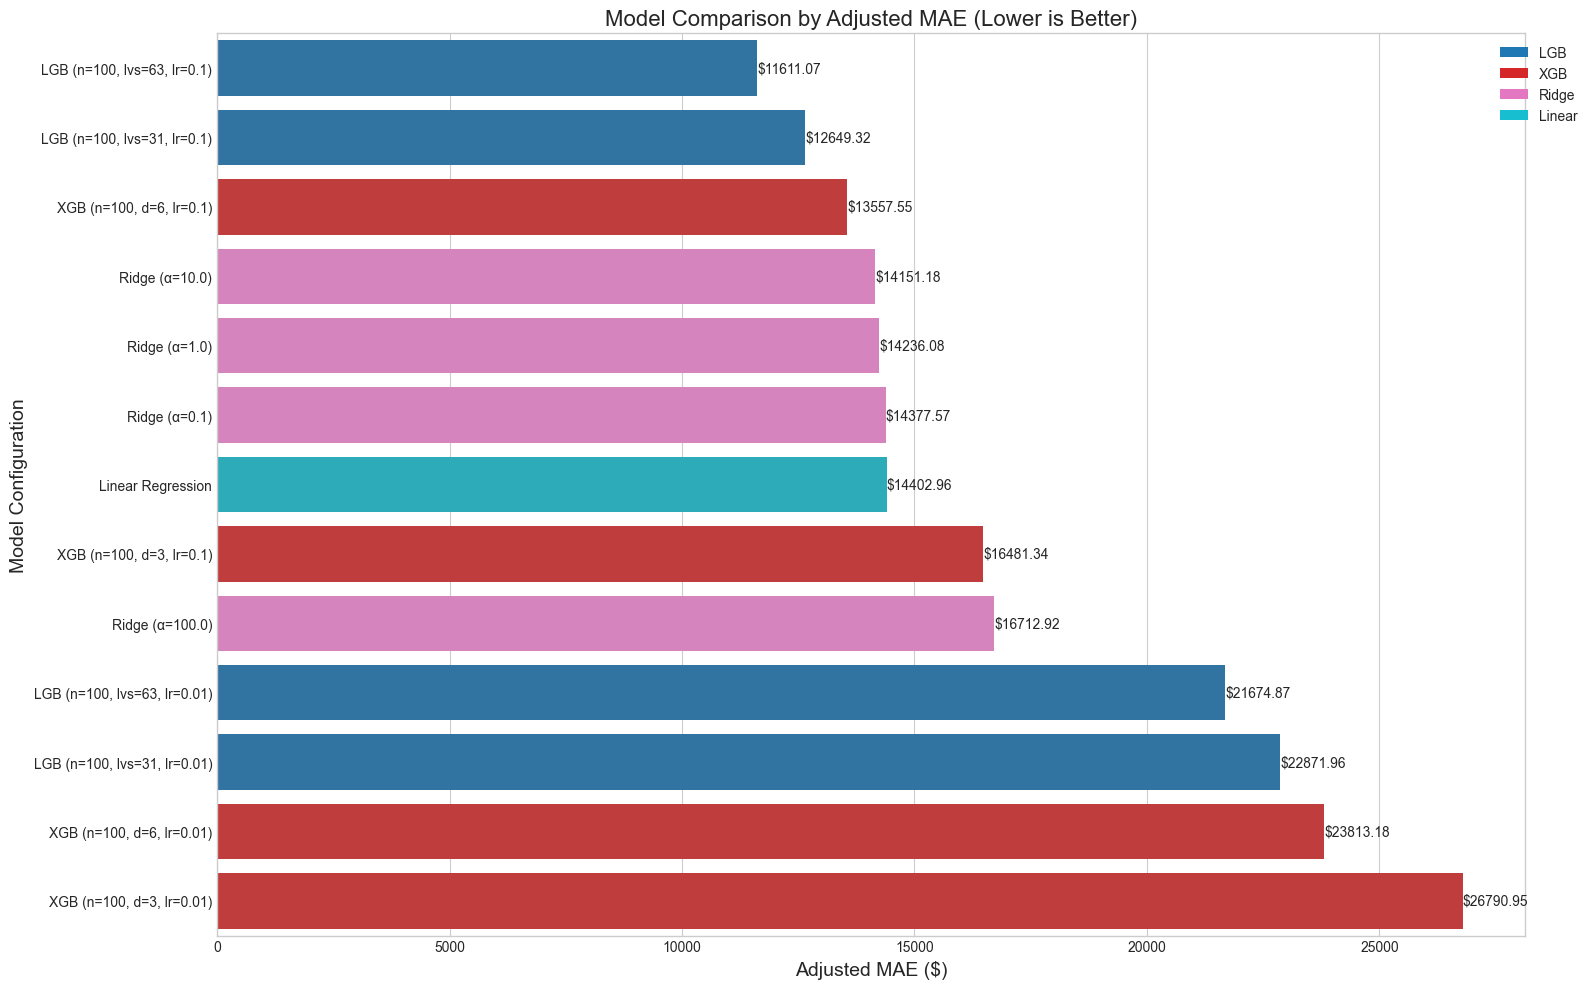

C:\Users\Sarthak\AppData\Local\Temp\ipykernel_14980\2994243279.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Within_10%', y='Model', data=within_10_df, palette=within_10_colors)


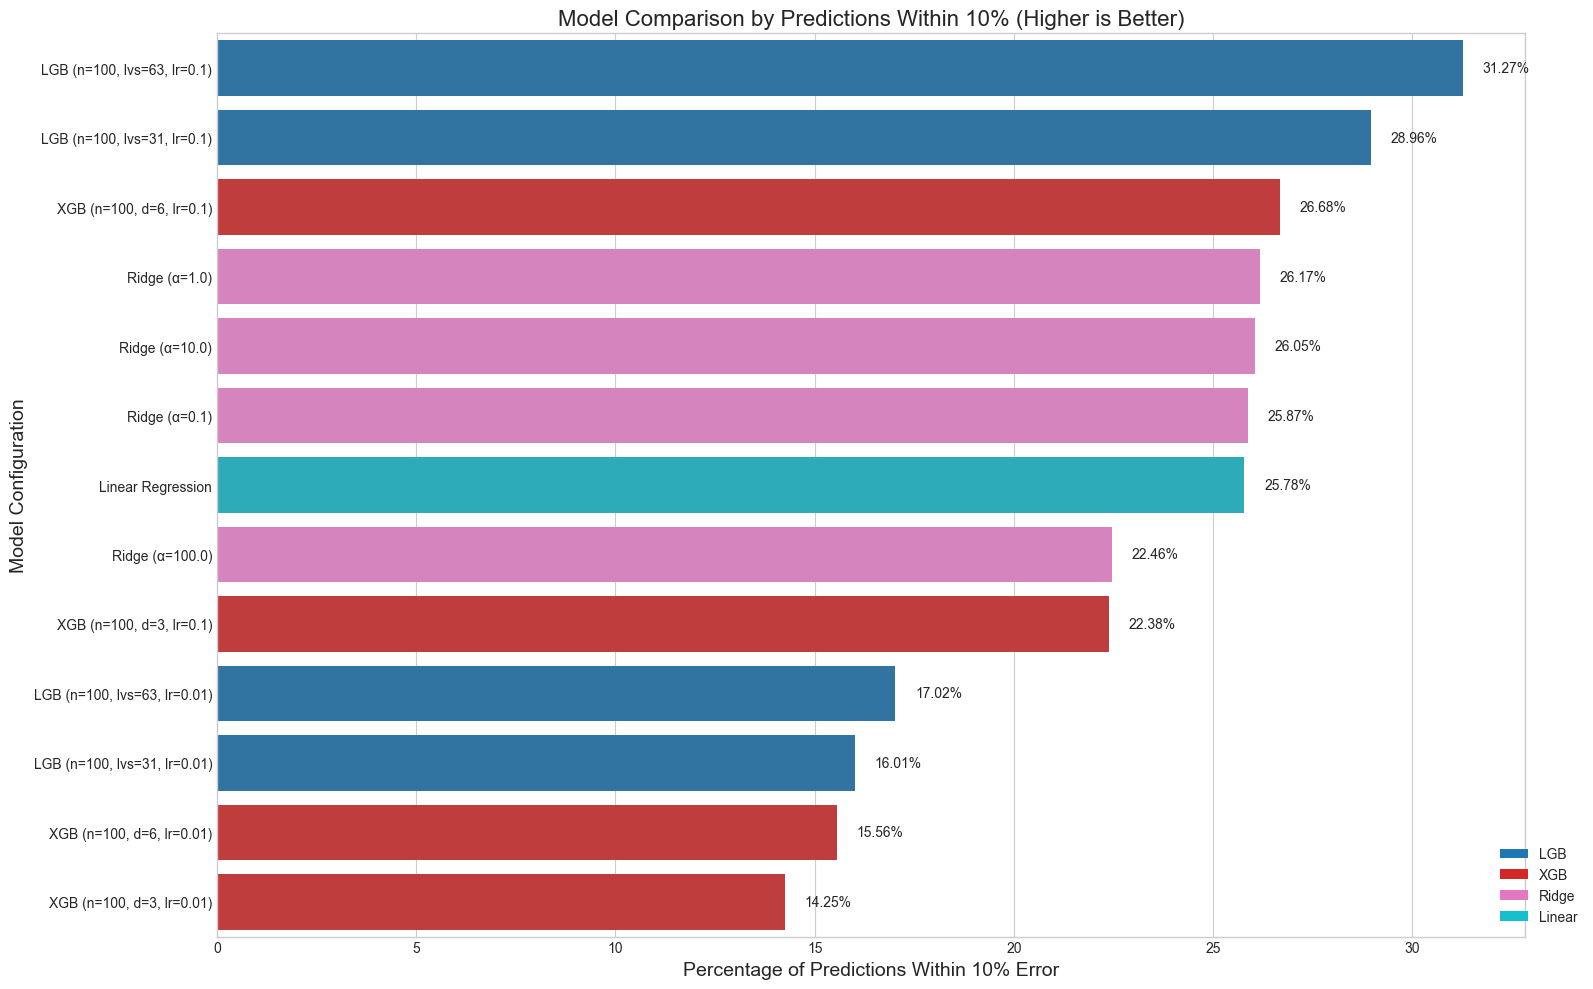

C:\Users\Sarthak\AppData\Local\Temp\ipykernel_14980\2994243279.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='R2', y='Model', data=r2_df, palette=r2_colors)


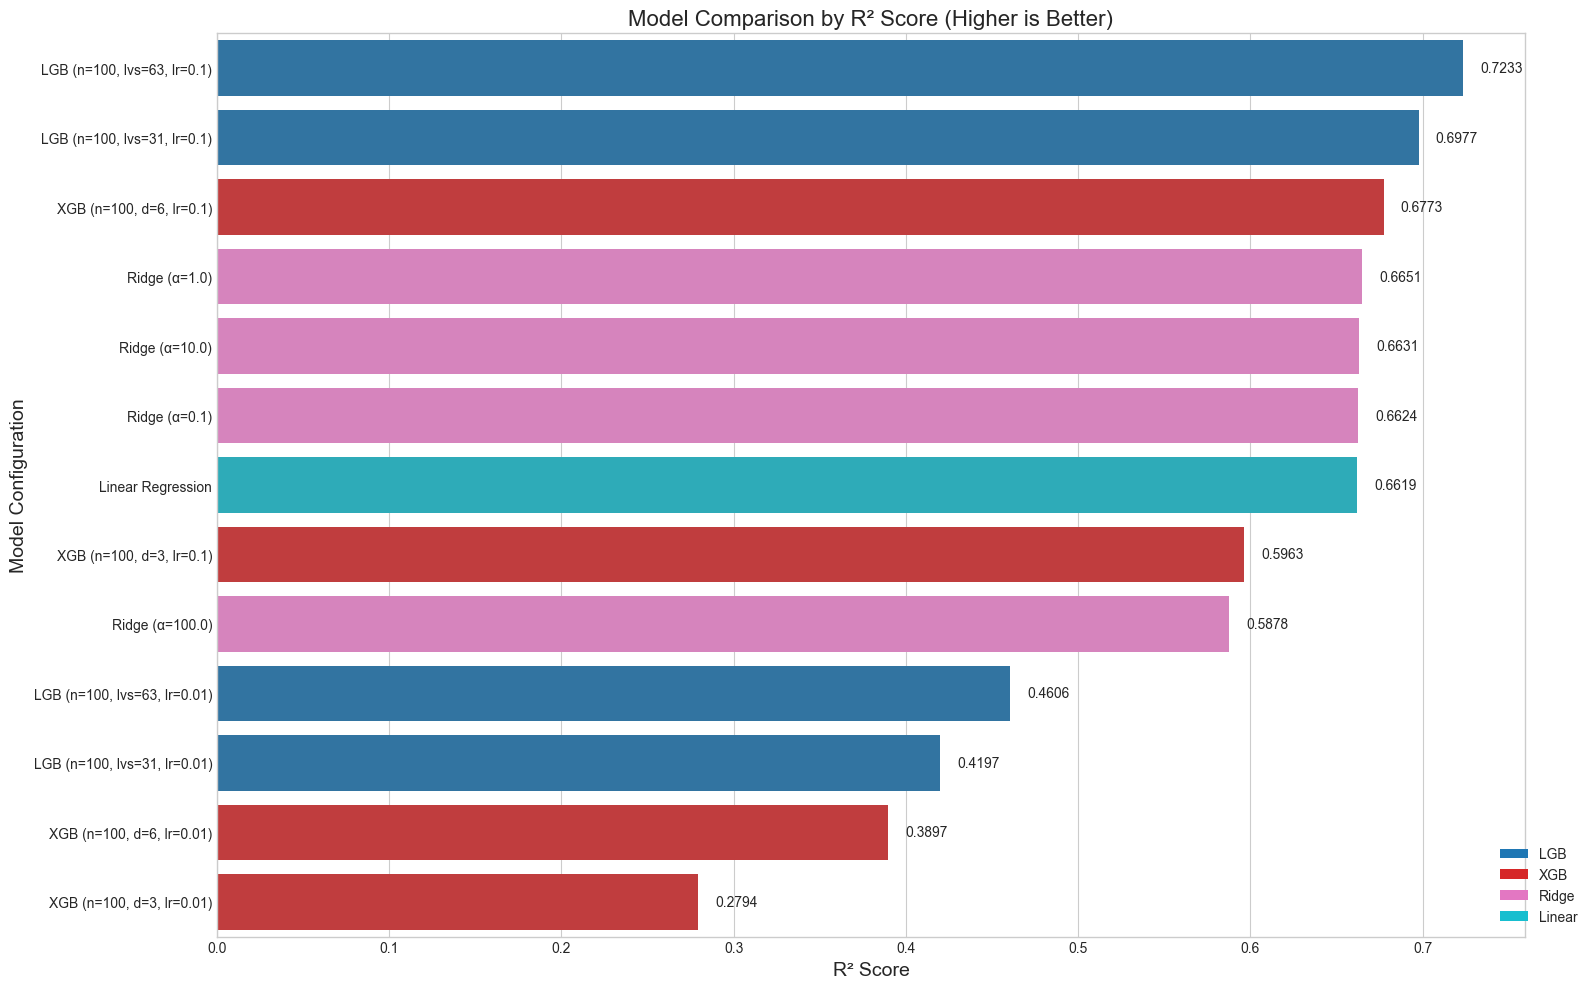


===== BEST MODELS =====
Best model by Adjusted MAE: LGB (n=100, lvs=63, lr=0.1)
Best model by Within 10%: LGB (n=100, lvs=63, lr=0.1)
Best model by R²: LGB (n=100, lvs=63, lr=0.1)

===== EXTREME ERROR ANALYSIS =====

Analyzing extreme errors for the best model: LGB (n=100, lvs=63, lr=0.1)
Number of extreme errors (>95th percentile): 1783
Error threshold: $56645.01

Summary statistics for extreme errors:
              Actual      Predicted          Error      Abs_Error  \
count    1783.000000    1783.000000    1783.000000    1783.000000   
mean   170772.301927  123824.276828   46948.025098   79997.544110   
std     65416.853907   33183.686977   69249.602869   24447.149590   
min     11000.000000   29797.695666 -187101.938082   56645.854582   
25%    130000.000000   99770.531670   56967.322559   62618.969546   
50%    187500.000000  124208.278276   67789.994858   71942.983426   
75%    235185.575000  148718.491272   86611.142024   88150.261220   
max    235185.575000  223730.388808  202

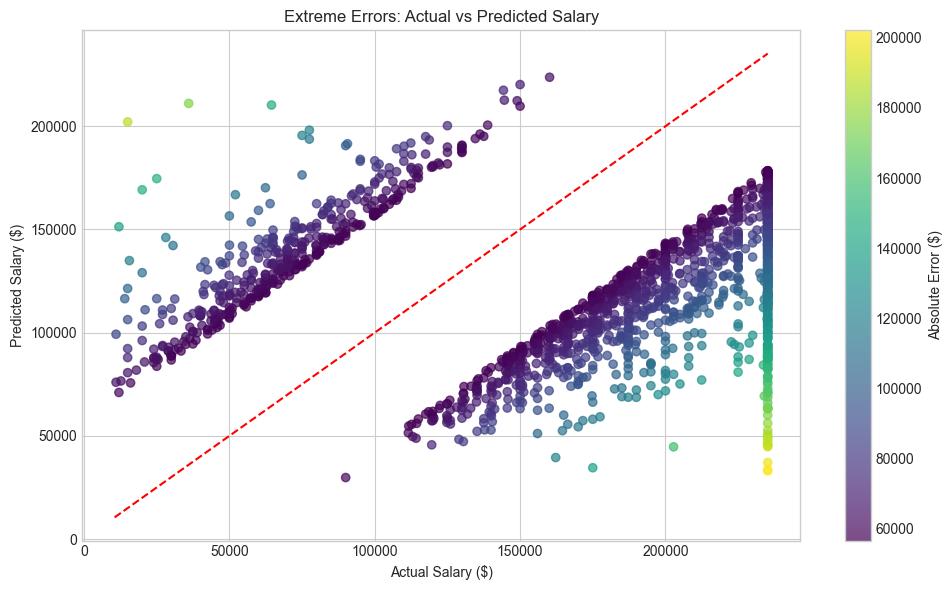

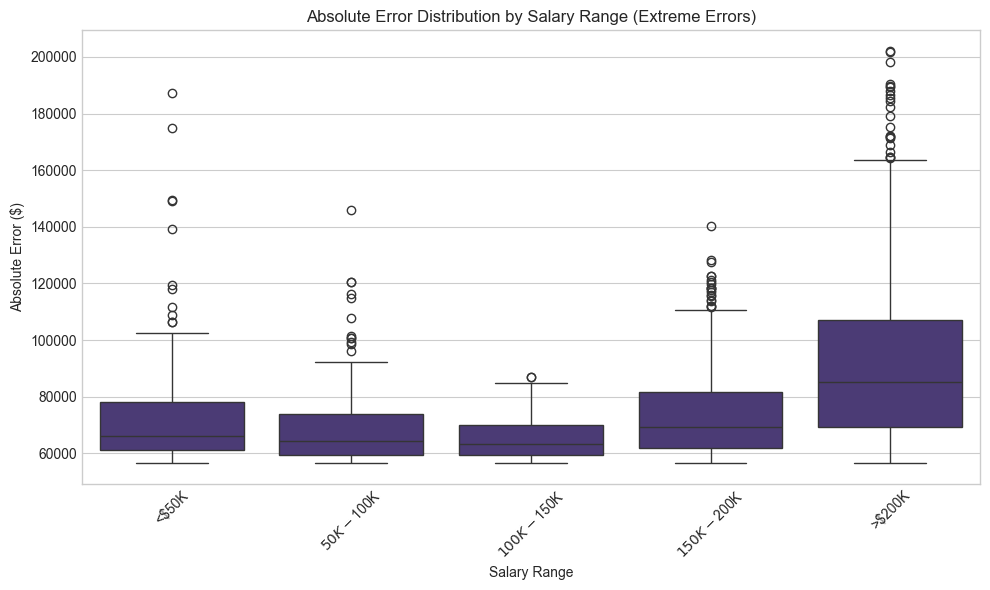


===== MODEL CALIBRATION ANALYSIS =====



C:\Users\Sarthak\AppData\Local\Temp\ipykernel_14980\2036177998.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = calibration_df.groupby('Actual_Bin').agg({


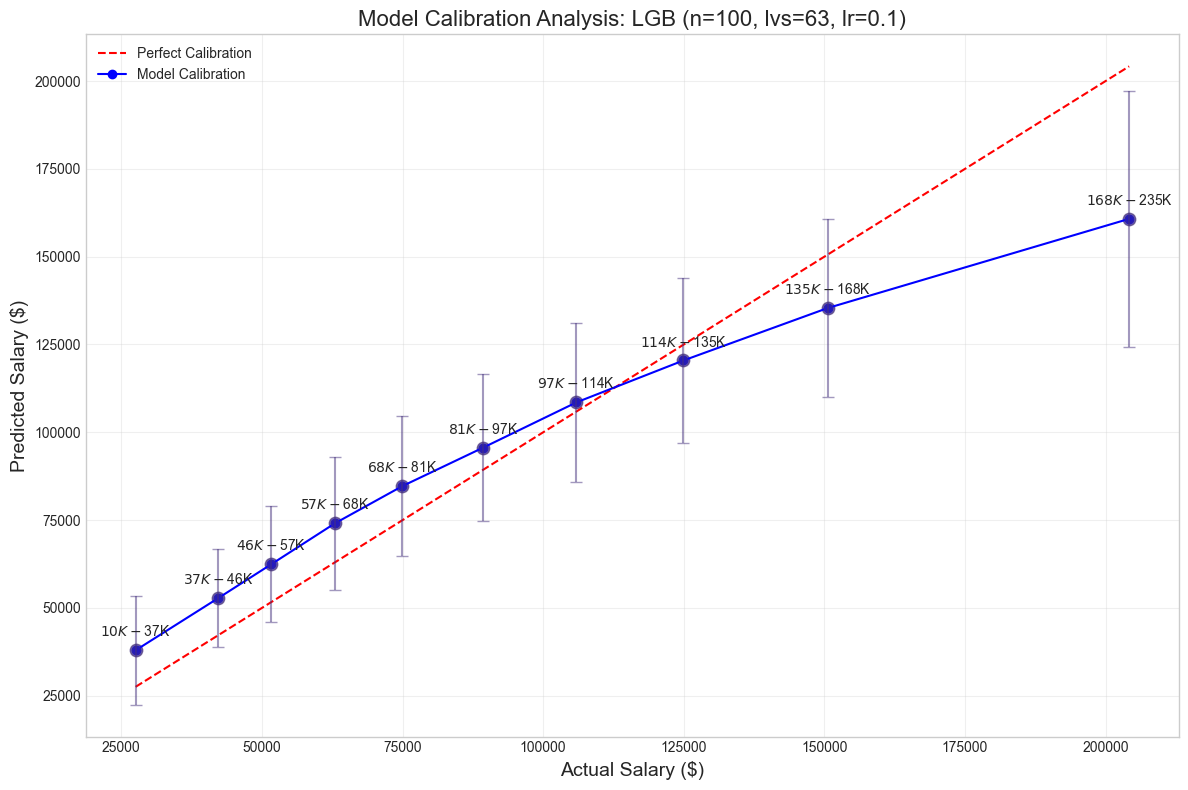

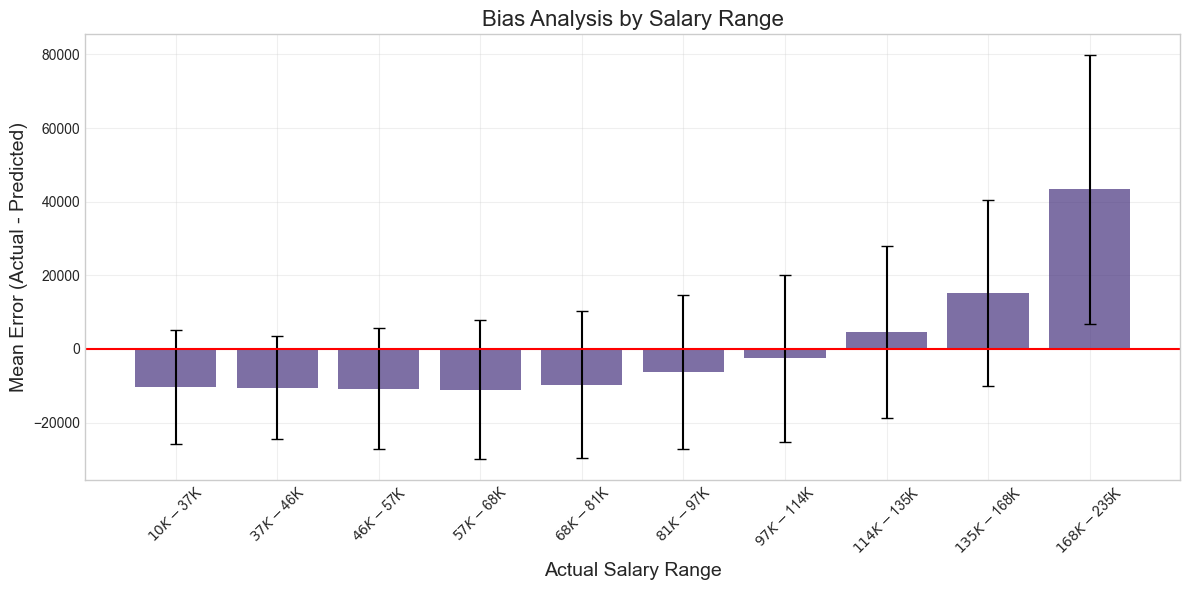

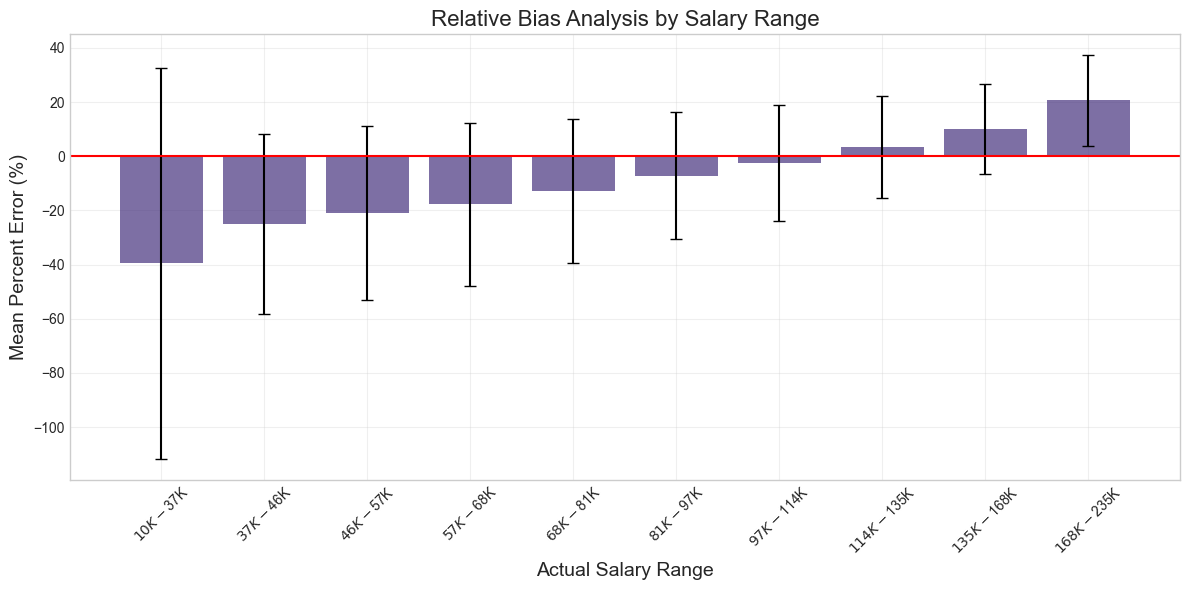

Bias-Variance Summary:
  Overall Bias (Mean Error): $138.73
  Error Variance: $765266437.63
  Mean Absolute Percent Error: 24.18%

Systematic Bias Analysis:
  Over-predictions: 19857 (55.7%)
  Under-predictions: 15786 (44.3%)

===== EVALUATION SUMMARY =====
The best overall model is: LGB (n=100, lvs=63, lr=0.1)
  Adjusted MAE: $11611.07
  Within 10%: 31.27%
  R²: 0.7233

Top 5 best performing models (by Adjusted MAE):


,Model,Adjusted_MAE,Adjusted_MAE_std,Within_10%,R2,Model_Type
12,"LGB (n=100, lvs=63, lr=0.1)",11611.069339,195.743347,31.265620,0.723286,LGB
10,"LGB (n=100, lvs=31, lr=0.1)",12649.322066,187.125265,28.959417,0.697677,LGB
8,"XGB (n=100, d=6, lr=0.1)",13557.547747,158.208136,26.684078,0.677348,XGB
3,Ridge (α=10.0),14151.181546,148.027181,26.047175,0.663061,Ridge
2,Ridge (α=1.0),14236.077259,139.525399,26.167810,0.665089,Ridge


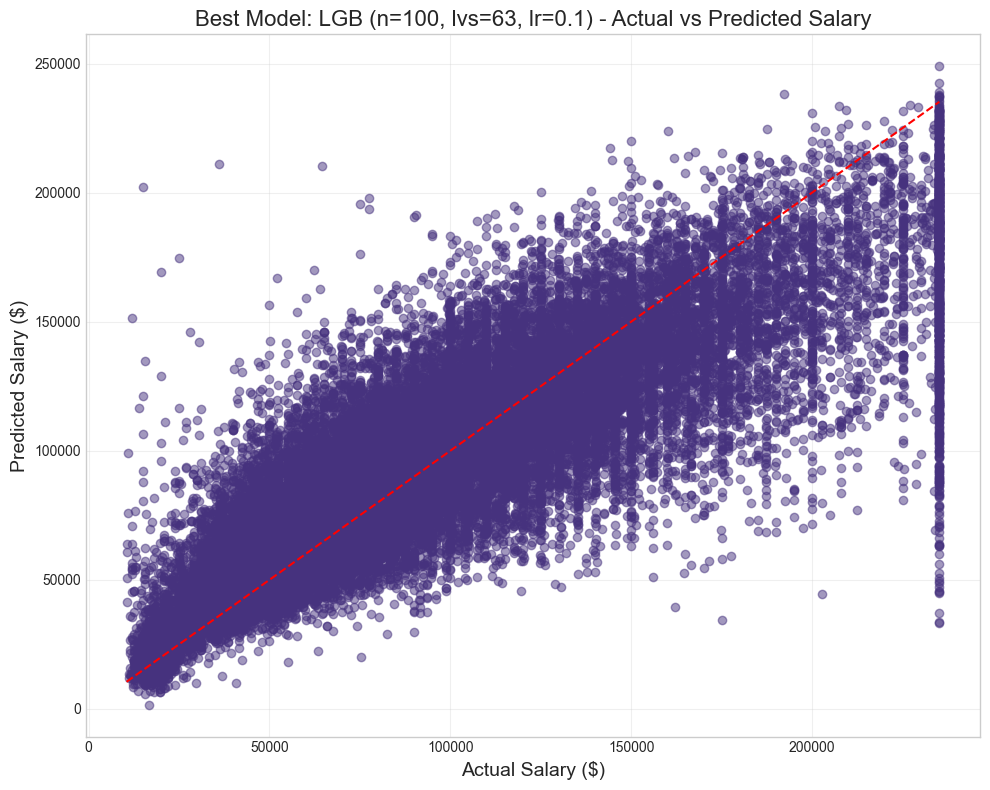

In [34]:
# Now execute with the updated return value
print("Starting comprehensive model evaluation...")
ablation_results, results_df, extreme_errors_df, calibration_summary = complete_evaluation_strategy(X, y_avg)

# Display the top 5 best models
print("\nTop 5 best performing models (by Adjusted MAE):")
display(results_df.head(5))

# Plot actual vs predicted for the best model
best_model_name = results_df.iloc[0]['Model']
best_model_results = ablation_results[best_model_name]

plt.figure(figsize=(10, 8))
plt.scatter(best_model_results['actuals'], best_model_results['predictions'], alpha=0.5)
plt.plot([min(best_model_results['actuals']), max(best_model_results['actuals'])], 
         [min(best_model_results['actuals']), max(best_model_results['actuals'])], 'r--')
plt.title(f'Best Model: {best_model_name} - Actual vs Predicted Salary', fontsize=16)
plt.xlabel('Actual Salary ($)', fontsize=14)
plt.ylabel('Predicted Salary ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


===== CALIBRATION ANALYSIS =====
Examining calibration summary by salary range:


,Actual_Bin,Actual_Mean,Predicted_Mean,Error_Mean,Error_Std,Percent_Error_Mean,Percent_Error_Std,Bin_Label
0,"(10499.999, 37440.0]",27532.898182,37930.495526,-10397.597344,15474.123783,-39.596969,72.265925,$10K-$37K
1,"(37440.0, 46544.0]",42180.993750,52743.442483,-10562.448733,14009.787314,-25.081882,33.197247,$37K-$46K
2,"(46544.0, 57200.0]",51692.392856,62469.953367,-10777.560511,16428.977999,-20.998011,31.963074,$46K-$57K
3,"(57200.0, 68837.344]",62995.785329,74104.945812,-11109.160483,18872.006932,-17.705012,30.051608,$57K-$68K
4,"(68837.344, 81120.0]",74961.180525,84677.435386,-9716.254861,19897.919512,-12.987996,26.578804,$68K-$81K
5,"(81120.0, 97500.0]",89338.486644,95641.158247,-6302.671603,20857.132264,-7.124185,23.433407,$81K-$97K
6,"(97500.0, 114750.4]",105924.840782,108526.777645,-2601.936863,22592.396690,-2.540121,21.388852,$97K-$114K
7,"(114750.4, 135200.0]",124935.197573,120445.880110,4489.317463,23386.991335,3.480849,18.771852,$114K-$135K
8,"(135200.0, 168700.0]",150566.544930,135360.773962,15205.770968,25247.724677,9.969261,16.716396,$135K-$168K
9,"(168700.0, 235185.575]",204183.039996,160767.268970,43415.771026,36537.466091,20.689600,16.786497,$168K-$235K


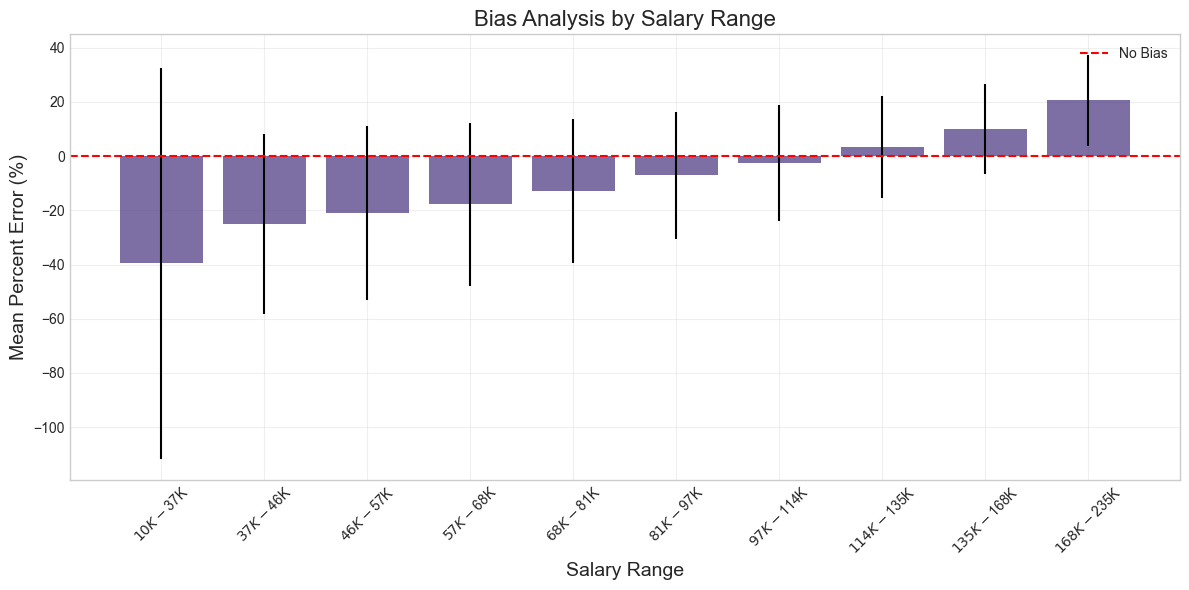

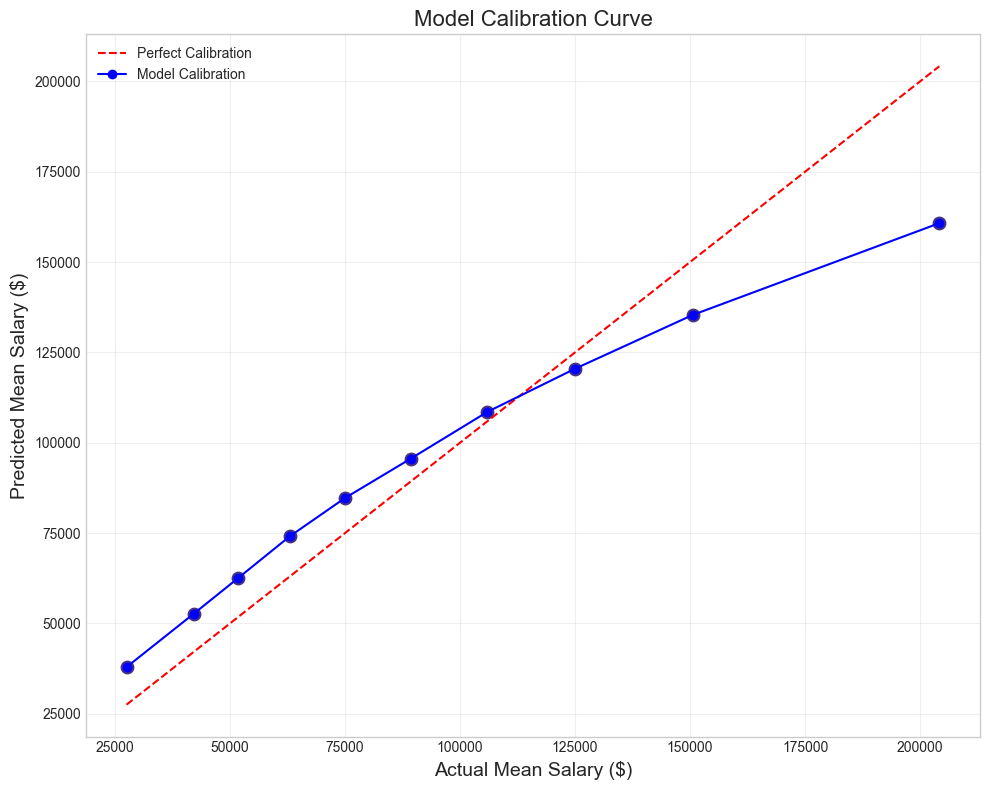

In [35]:
# Now use the calibration summary to create additional visualizations
print("\n===== CALIBRATION ANALYSIS =====")
print("Examining calibration summary by salary range:")
display(calibration_summary)

# Create a visualization showing bias across different salary ranges
plt.figure(figsize=(12, 6))
plt.bar(calibration_summary['Bin_Label'], 
        calibration_summary['Percent_Error_Mean'], 
        yerr=calibration_summary['Percent_Error_Std'], 
        alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', label='No Bias')
plt.title('Bias Analysis by Salary Range', fontsize=16)
plt.xlabel('Salary Range', fontsize=14)
plt.ylabel('Mean Percent Error (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Compare actual mean vs predicted mean by bin (calibration curve)
plt.figure(figsize=(10, 8))
plt.scatter(calibration_summary['Actual_Mean'], calibration_summary['Predicted_Mean'], s=80)
# Perfect prediction line
plt.plot([calibration_summary['Actual_Mean'].min(), calibration_summary['Actual_Mean'].max()],
         [calibration_summary['Actual_Mean'].min(), calibration_summary['Actual_Mean'].max()], 
         'r--', label='Perfect Calibration')
# Actual line
plt.plot(calibration_summary['Actual_Mean'], calibration_summary['Predicted_Mean'], 'b-o', label='Model Calibration')

plt.title('Model Calibration Curve', fontsize=16)
plt.xlabel('Actual Mean Salary ($)', fontsize=14)
plt.ylabel('Predicted Mean Salary ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()